# Test: Identify generic human genes on test set

This notebook performs the following steps to identify generic genes
1. Simulates N gene expression experiments using [ponyo](https://github.com/ajlee21/ponyo)
2. Perform DE analysis to get association statistics for each gene

In this case the DE analysis is based on the experimental design of the template experiment, described in the previous [notebook](1_process_recount2_data.ipynb). The template experiment is [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients. So the DE analysis is comparing tumor vs normal in this case.

3. For each gene, aggregate statsitics across all simulated experiments 
4. Rank genes based on this aggregated statistic

**Evaluation:**
We want to compare our ranking using ponyo, compared to the ranking found from Crow et. al.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import pandas as pd
import numpy as np
import pickle
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from ponyo import utils, simulate_expression_data
from generic_expression_patterns_modules import calc, process

Using TensorFlow backend.
/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [2]:
# Read in config variables
base_dir = os.path.abspath(
    os.path.join(os.getcwd(), "../")
)

config_file = os.path.abspath(
    os.path.join(base_dir, "configs", "config_test.tsv")
)

params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
num_runs = params['num_simulated']
project_id = params['project_id']
metadata_col_id = params['metadata_colname']
template_data_file = params['template_data_file']
original_compendium_file = params['compendium_data_file']
normalized_compendium_file = params['normalized_compendium_data_file']
scaler_file = params['scaler_transform_file']
col_to_rank_genes = params['rank_genes_by']
compare_genes = params['compare_genes']

gene_summary_file = os.path.join(
    base_dir, 
    dataset_name, 
    "generic_gene_summary.tsv"
)

# Load pickled file
scaler = pickle.load(open(scaler_file, "rb"))

In [4]:
# Create results directories
output_dirs = [
    os.path.join(local_dir, "pseudo_experiment"),
    os.path.join(local_dir, "DE_stats"),
]

# Create `output_dirs`
for each_dir in output_dirs:
    os.makedirs(each_dir, exist_ok=True)

### Simulate experiments using selected template experiment

In [5]:
# Simulate multiple experiments
for run_id in range(num_runs):
    simulate_expression_data.shift_template_experiment(
        normalized_compendium_file,
        project_id,
        metadata_col_id,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        run_id
    )

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
# Check reproducibility of simulated experiments -- Found 318 columns with differences ~0.1
#template_path = "data/test_simulated_data_SRP012656_0.txt"
#template_df = pd.read_csv(template_path, sep="\t", header=0, index_col=0)
#output_path = os.path.join(local_dir, "pseudo_experiment", "selected_simulated_data_SRP012656_0.txt")
#output_df = pd.read_csv(output_path, sep="\t", header=0, index_col=0)
#assert np.all(np.isclose(output_df.values, template_df.values)), (
#    output_df.iloc[
#        np.where(~np.all(np.isclose(output_df.values, template_df.values), axis=1))[0],
#        np.where(~np.all(np.isclose(output_df.values, template_df.values), axis=0))[0],
#    ],
#)

In [7]:
# Check reproducibility of simulated experiments
# Commenting this out for now 
#template_path = "data/test_simulated_data_SRP012656_1.txt"
#output_path = os.path.join(local_dir, "pseudo_experiment", "selected_simulated_data_SRP012656_1.txt")
#assert np.all(np.isclose(
#    pd.read_csv(output_path, sep="\t", header=0, index_col=0).values,
#    pd.read_csv(template_path, sep="\t", header=0, index_col=0).values
#    ))

Since this experiment contains both RNA-seq and smRNA-seq samples which are in different ranges so we will drop smRNA samples so that samples are within the same range. The analysis identifying these two subsets of samples can be found in this [notebook](../explore_data/0_explore_input_data.ipynb)

In [8]:
# Remove subset of samples
smRNA_samples = [
    "SRR493961",
    "SRR493962",
    "SRR493963",
    "SRR493964",
    "SRR493965",
    "SRR493966",
    "SRR493967",
    "SRR493968",
    "SRR493969",
    "SRR493970",
    "SRR493971",
    "SRR493972"
]

process.subset_samples(
    smRNA_samples,
    num_runs,
    local_dir,
    project_id
)

In [9]:
# Round simulated read counts to int in order to run DESeq
process.recast_int(num_runs, local_dir, project_id)

### Differential expression analysis

In [10]:
# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_groups.tsv"
)

In [11]:
# Check ordering of sample ids is consistent between gene expression data and metadata
process.compare_and_reorder_samples(template_data_file, metadata_file)

sample ids are ordered correctly


In [12]:
%%R -i metadata_file -i project_id -i template_data_file -i local_dir

source('../generic_expression_patterns_modules/DE_analysis.R')

get_DE_stats_limma(metadata_file,
                   project_id, 
                   template_data_file,
                   "template",
                   local_dir,
                   "real")

/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/dhu/miniconda3/

[1] 2953


In [13]:
# Check ordering of sample ids is consistent between gene expression data and metadata
for i in range(num_runs):
    simulated_data_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}.txt"
    )
        
    process.compare_and_reorder_samples(simulated_data_file, metadata_file)

sample ids are ordered correctly
sample ids are ordered correctly


In [14]:
%%R -i metadata_file -i project_id -i base_dir -i local_dir -i num_runs

source('../generic_expression_patterns_modules/DE_analysis.R')

for (i in 0:(num_runs-1)){
    simulated_data_file <- paste(local_dir, 
                                 "pseudo_experiment/selected_simulated_data_",
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    
    run_output <- get_DE_stats_limma(metadata_file,
                                     project_id, 
                                     simulated_data_file,
                                     "simulated",
                                     local_dir,
                                     i)
}

In [15]:
assert os.path.exists(
    os.path.join(local_dir, "DE_stats", "DE_stats_simulated_data_SRP012656_0.txt")
)

### Rank genes

In [16]:
# Concatenate simulated experiments
simulated_DE_stats_all = process.concat_simulated_data(
    local_dir, num_runs, project_id, 'DE'
)

print(simulated_DE_stats_all.shape)

(35574, 7)


In [17]:
# Take absolute value of logFC and t statistic
simulated_DE_stats_all = process.abs_value_stats(simulated_DE_stats_all)

In [18]:
# Aggregate statistics across all simulated experiments
simulated_DE_summary_stats = calc.aggregate_stats(
    col_to_rank_genes,
    simulated_DE_stats_all,
    'DE'
)

In [19]:
# Load association statistics for template experiment
template_DE_stats_file = os.path.join(
    local_dir,
    "DE_stats",
    "DE_stats_template_data_"+project_id+"_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_file,
    header=0,
    sep='\t',
    index_col=0
)

# Take absolute value of logFC and t statistic
template_DE_stats = process.abs_value_stats(template_DE_stats)

# Rank genes in template experiment
template_DE_stats = calc.rank_genes_or_pathways(
    col_to_rank_genes,
    template_DE_stats,
    True
)

In [20]:
# Rank genes in simulated experiments
simulated_DE_summary_stats = calc.rank_genes_or_pathways(
    col_to_rank_genes,
    simulated_DE_summary_stats,
    False
)

### Gene summary table

In [21]:
summary_gene_ranks = process.generate_summary_table(
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir
)

summary_gene_ranks.head()

/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


(17787, 13)


,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
SFTPC,SFTPC,7.114416e-07,17787.0,513007.833333,1.574160e-06,17781.0,23823.625000,11986.815229,2,40.810190
IGHG1,IGHG1,3.802230e-02,17786.0,415243.500000,2.249261e-01,17635.0,3795.625000,3287.516202,2,125.154630
SFTPA2,SFTPA2,1.104286e-05,17785.0,409987.583333,1.492387e-06,17773.0,15941.541667,6762.356776,2,58.270519
COL1A1,COL1A1,3.165747e-02,17784.0,128011.916667,5.652296e-01,15836.0,694.750000,713.824296,2,178.359251
A2M,A2M,2.206779e-07,17783.0,120229.083333,2.468669e-07,17778.0,21457.958333,11637.622330,2,8.487225


In [22]:
summary_gene_ranks.to_csv(gene_summary_file, sep='\t')

In [23]:
# Check reproducibility of summary ranks
#template_path = "data/test_generic_gene_summary.tsv"
#template_df = pd.read_csv(template_path, sep="\t", header=0, index_col=0)
#output_df = pd.read_csv(gene_summary_file, sep="\t", header=0, index_col=0)
#assert (template_df["Gene ID"].values == output_df["Gene ID"].values).all(),template_df.loc[template_df["Gene ID"].values != output_df["Gene ID"].values,"Gene ID"]

#assert np.all(np.isclose(
#    template_df[["Rank (Real)", "Rank (simulated)"]].values,
#    output_df[["Rank (Real)", "Rank (simulated)"]].values),
#    output_df[["Rank (Real)", "Rank (simulated)"]].iloc[
#        np.where(~np.all(np.isclose(output_df[["Rank (Real)", "Rank (simulated)"]].values, template_df[["Rank (Real)", "Rank (simulated)"]].values), axis=1))[0],
#        np.where(~np.all(np.isclose(output_df[["Rank (Real)", "Rank (simulated)"]].values, template_df[["Rank (Real)", "Rank (simulated)"]].values), axis=0))[0],
#    ]

#)

### Compare gene ranking
Studies have found that there are some genes that are more likely to be differentially expressed even across a wide range of experimental designs. These *generic genes* are not necessarily specific to the biological process being studied but instead represents a more systematic change. 

We want to compare the ability to detect these generic genes using our method vs those found by [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

r = 0.19729376060317863
p = 2.3680586513508507e-150
ci_low = 0.18230208153853386
ci_high = 0.21229798948946343


/home/dhu/miniconda3/envs/generic_expression/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


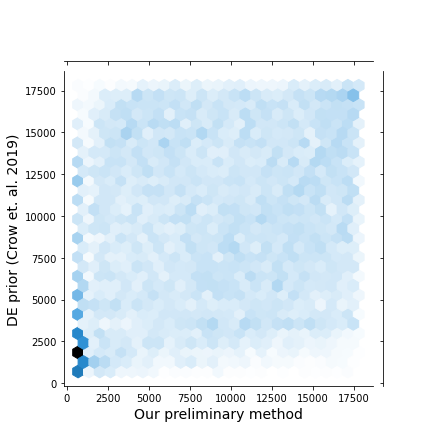

In [24]:
if compare_genes:
    DE_prior_file = params['reference_gene_file']
    ref_gene_col = params['reference_gene_name_col']
    ref_rank_col = params['reference_rank_col']
    fig_filename = os.path.join(
        local_dir, 
        f"gene_ranking_{col_to_rank_genes}.svg"
    )
    
    correlations = process.compare_gene_ranking(
        summary_gene_ranks,
        DE_prior_file,
        ref_gene_col,
        ref_rank_col,
        fig_filename
    )
    
    r, p = correlations['r'], correlations['p']
    
    expected_r = 0.19729376060317863
    expected_p = 2.3680586513508507e-150
    
    assert(
        np.all(
            np.isclose([r, p], [expected_r, expected_p])
        )
    )

**Takeaway:**
Based on the correlation plot, we can see that our simulation method is very good at capturing variability in genes that are very low or very high in the DE rank (i.e. are significantly differentially expressed often across different studies). These results serve to validate that our method can be used to identify these generic genes, as we were able to recapitulate the some of the generic genes as those identified by Crow et. al. Additionally, our method extends the Crow et. al. work, which used array data, and since here we used RNA-seq.